# Import

In [58]:
import numpy as np
import scipy
from collections import OrderedDict
from typing import List, Tuple
import matplotlib.pyplot as plt
import pandas as pd
import time
import tqdm

import cirq
import pyscf
import openfermion
import openfermionpyscf 
import itertools

from pyscf import gto, scf, fci
from openfermion.transforms import jordan_wigner, get_fermion_operator
from openfermionpyscf import run_pyscf
from openfermion.utils import count_qubits
from openfermion.linalg import jw_hartree_fock_state
from openfermion.circuits import simulate_trotter
from openfermion import (
    MolecularData, get_sparse_operator, get_ground_state, FermionOperator,
    jw_get_ground_state_at_particle_number,
    expectation, uccsd_convert_amplitude_format,
    get_interaction_operator, QubitOperator, eigenspectrum,
    InteractionOperator
)

In [269]:
class Timer:
    def __init__(self):
        self.enable_debug = True
        self._last_point = time.time()
        self._point_stock = OrderedDict()

    def time_check(self, name: str = None):
        current_point = time.time()
        elapsed = current_point - self._last_point
        if name is not None and self.enable_debug:
            self._point_stock[name] = elapsed
            print(f"TimeCheck: {name} : {elapsed}s")
        self._last_point = current_point

    def reset(self):
        self._last_point = time.time()
        self._point_stock = OrderedDict()

timer = Timer()
timer.enable_debug = False
timer2 = Timer()
timer2.enable_debug = False

# Load Hamiltonian for HeH+

- The full configuration interaction Hamiltonian for this system has dimension 4 , and can be written compactly as
    $$
    \mathcal{H}(R)=\sum_{i \alpha} h_{\alpha}^{i}(R) \sigma_{\alpha}^{i}+\sum_{i j \alpha \beta} h_{\alpha \beta}^{i j}(R) \sigma_{\alpha}^{i} \sigma_{\beta}^{j}
    $$
    The coefficients $h_{\alpha}^{i}(R)$ and $h_{\alpha \beta}^{i j}(R)$ were determined using the PSI3 computational package ${ }^{32}$ and are tabulated in Supplementary Table 2 .

In [2]:
H_df = pd.read_csv("/VQE/Original_VQE/H_R.txt", delimiter=' ')
H_df[H_df.columns[H_df.columns != 'R']]/=2.0  # divided by 2 is the real value
H_df.head(3)

,R,II,IX,IZ,XI,XX,XZ,ZI,ZX,ZZ
0,0.05,16.97785,-0.07575,-1.23920,-0.07575,0.07060,0.07575,-1.23920,0.07575,0.13730
1,0.10,6.68025,-0.08130,-1.21840,-0.08130,0.10485,0.08130,-1.21840,0.08130,0.10405
2,0.15,3.41160,-0.07685,-1.19005,-0.07685,0.13400,0.07685,-1.19005,0.07685,0.07560


- Define the operator corresponding to the Hamiltonian term. Then combing the operators and the coefficients, we can reconstruct the Hamiltonian.

In [3]:
pauliX=np.array([[0,1],
                 [1,0]],
                dtype=complex)
pauliZ=np.array([[1,0],
                 [0,-1]],
                dtype=complex)

# Define dictionary of necessary Pauli operators (four-dimensional) as matrices.

operator_list={
    "II": np.kron(np.identity(2),np.identity(2)).astype(complex),
    "IX": np.kron(np.identity(2),pauliX).astype(complex),
    "IZ": np.kron(np.identity(2),pauliZ).astype(complex),
    "XI": np.kron(pauliX,np.identity(2)).astype(complex), 
    "XX": np.kron(pauliX,pauliX).astype(complex),
    "XZ": np.kron(pauliX,pauliZ).astype(complex),
    "ZI": np.kron(pauliZ,np.identity(2)).astype(complex),
    "ZX": np.kron(pauliZ,pauliX).astype(complex),
    "ZZ": np.kron(pauliZ,pauliZ).astype(complex)
    }

# Original VQE method:

- Algorithm:
  - Prepare the state according to the given parameters.
  - Calculate the Hamiltonian matrix according to the given Hamiltonian information.
  - Calculate the expectation energy value according to the state and the Hamiltonian.
  - Optimized the parameters to given the lowest energy with Nelder-Mead algorithm.

## Prepare the state from the parameters

- An arbitrary 2-qubit pure state can be parametrized in the following form
    $$
    \begin{aligned}
    |\psi\rangle=& \cos \left(\frac{\theta_{0}}{2}\right) \cos \left(\frac{\theta_{1}}{2}\right)\left|0_{1} 0_{2}\right\rangle \\
    &+\cos \left(\frac{\theta_{0}}{2}\right) \sin \left(\frac{\theta_{1}}{2}\right) e^{i \omega_{1}}\left|0_{1} 1_{2}\right\rangle \\
    &+\sin \left(\frac{\theta_{0}}{2}\right) e^{i \omega_{0}} \cos \left(\frac{\theta_{2}}{2}\right)\left|1_{1} 0_{2}\right\rangle \\
    &+\sin \left(\frac{\theta_{0}}{2}\right) e^{i \omega_{0}} \sin \left(\frac{\theta_{2}}{2}\right) e^{i \omega_{2}}\left|1_{1} 1_{2}\right\rangle, \\
    & \theta_{i} \in[0, \pi], \omega_{i} \in[0,2 \pi] .
    \end{aligned}
    $$
    - So here it use 6 parameters to form the $\left\{\theta_{i}\right\} = \left\{\theta_{0}, \theta_{1}, \theta_{2}, \omega_{0}, \omega_{1}, \omega_{2}\right\}$.

In [4]:
def get_state_from_parameters(parameters: List[float]) -> List[complex]:
    """
    Get the state from the parameters.
    
    Args:
        parameters: List of six parameters
    
    returns:
        state: product vector of the state
    """

    # Get the parameters from the input list
    theta0=parameters[0]
    theta1=parameters[1]
    theta2=parameters[2]
    w0=parameters[3]
    w1=parameters[4]
    w2=parameters[5]
    
    # Calculate complex coordinates from parameters
    a=np.cos(theta0/2)*np.cos(theta1/2)
    b=np.cos(theta0/2)*np.sin(theta1/2)*np.exp(w1*1j)
    c=np.sin(theta0/2)*np.exp(w0*1j)*np.cos(theta2/2)
    d=np.sin(theta0/2)*np.exp(w0*1j)*np.sin(theta2/2)*np.exp(w2*1j)

    # construct the state
    zero_v = np.array([1, 0])
    one_v = np.array([0, 1])
    phi_vector = a*np.kron(zero_v, zero_v) + b*np.kron(zero_v, one_v) +\
                 c*np.kron(one_v, zero_v) + d*np.kron(one_v, one_v)
    return phi_vector

## Get energy from direct matrix operation

In [5]:
def get_Hamiltonian_matrix(H_pd: pd.Series) -> np.array:
    """
    Get the Hamiltonian from the pd.series.
    
    Args:
        H_pd: contain the Pauli operator and its coefficients
    
    returns:
        H_matrix: matrix presentation of the Hamiltonian
    """
    
    H_matrix = np.complex128(0)
    for key in H_pd.keys():
        coeff = complex(H_pd[key])
        hm = operator_list.get(key, 0+0j)
        H_matrix += coeff * hm  # Hamiltonian = coefficients * operator
    return H_matrix


In [6]:
def get_expectation_from_matrix_operation(parameters: List[float], H_df: pd.Series, repetitions: int = 100) -> float:
    """
    Get the expected value of the energy from : <bra|H|ket>

    Args:
        parameters: List of six parameters used to prepare the state
        H_df: contain the Hamiltonian information to prepare the Hamiltonian
        repetitions: redundant, no use here

    Returns:
        energy: The expected value of the energy from : <bra|H|ket>
    """

    bra = get_state_from_parameters(parameters)
    H_matrix = get_Hamiltonian_matrix(H_df)
    ket = np.array(bra).conj().T
    return np.real(np.dot(np.dot(bra, H_matrix),ket))

In [7]:
def get_expectation_from_operation(parameters: List[float], operator: str, repetitions: int = 100) -> float:
    """
    Get the expected value of the energy from : <bra|H|ket>

    Args:
        parameters: List of six parameters used to prepare the state
        H_df: contain the Hamiltonian information to prepare the Hamiltonian
        repetitions: redundant, no use here

    Returns:
        energy: The expected value of the energy from : <bra|H|ket>
    """
    
    bra = get_state_from_parameters(parameters)
    H_matrix = operator_list[operator]
    ket = np.array(bra).conj().T
    return np.real(np.dot(np.dot(bra, H_matrix),ket))

## Get energy from Cirq simulation

### Prepare the initial two qubits state with [Schmidt decomposition](https://arxiv.org/pdf/2107.09155.pdf)

1. Any pure state $|\psi\rangle \in \mathbb{C}^{(m\times n)}$ can be represented as
    $$
    |\psi\rangle=\sum_{i=1}^{k} \lambda_{i}\left|\alpha_{i}\right\rangle \otimes\left|\beta_{i}\right\rangle  \tag{1}
    $$
    with $k=\min (m, n)$. The set of bases vectors $\left\{\left|\alpha_{i}\right\rangle\right\} \in \mathbb{C}^{m}$ and $\left\{\left|\beta_{i}\right\rangle\right\} \in \mathbb{C}^{n}$ are called Schmidt bases which are orthogonal in respective Hilbert spaces. The coefficients $\lambda_{i}$ in equation (1) are called Schmidt coefficients.
2. We can always represent the pure state $|\psi\rangle \in \mathbb{C}^{m\times n}$ using computational bases as
   $$
   |\psi\rangle=\sum_{i=1}^{m} \sum_{j=1}^{n} C_{i j}\left|e_{i}\right\rangle \otimes\left|f_{j}\right\rangle, \tag{2}
   $$
   where $\left|e_{i}\right\rangle \in \mathbb{C}^{m}$ and $\left|f_{j}\right\rangle \in \mathbb{C}^{n}$.
   If we do the SVD of the matrix $C$ in (2) and write
   $$
   C=U \Sigma V^{\dagger}\tag{3}
   $$
   then without going into the mathematical details, from the three equations (1), (2), and (3) we can show that
   $$
   \sigma_{i i}=\lambda_{i},\left|\alpha_{i}\right\rangle=\sum_k U_{ki}\left|e_{k}\right\rangle, \text { and }\left|\beta_{i}\right\rangle=\sum_k V^{\dagger}_{ik}\left|f_{k}\right\rangle=\sum_k V^{*}_{ki}\left|f_{k}\right\rangle
   $$
   where $\sigma_{i i} = 0 \in {\Sigma = \{\sigma_{ij}\}}$ for $i\neq j$. The Unitary $U$ (and $V^{\dagger}$) can be decomposed to [single qubit rotation gate](https://www.osti.gov/servlets/purl/889415):
   $$
   \begin{aligned}
    U&=e^{i \theta_{0}} e^{-i \theta_{1} \sigma_{z} / 2} e^{-i \theta_{2} \sigma_{y} / 2} e^{-i \theta_{3} \sigma_{z} / 2}\\
    &=e^{i \theta_{0}}\left[\begin{array}{cc}
    e^{-i \theta_{1} / 2} & 0 \\
    0 & e^{i \theta_{1} / 2}
    \end{array}\right]\left[\begin{array}{cc}
    \cos \left(\frac{\theta_{2}}{2}\right) & -\sin \left(\frac{\theta_{2}}{2}\right) \\
    \sin \left(\frac{\theta_{2}}{2}\right) & \cos \left(\frac{\theta_{2}}{2}\right)
    \end{array}\right]\left[\begin{array}{cc}
    e^{-i \theta_{3} / 2} & 0 \\
    0 & e^{i \theta_{3} / 2}
    \end{array}\right]\\
    &=e^{i \theta_{0}}\left[\begin{array}{cc}
    e^{-i (\theta_{1}+\theta_{3}) / 2}\cos \left(\frac{\theta_{2}}{2}\right) & -e^{-i (\theta_{1}-\theta_{3}) / 2}\sin \left(\frac{\theta_{2}}{2}\right) \\
    e^{i (\theta_{1}-\theta_{3}) / 2}\sin \left(\frac{\theta_{2}}{2}\right) & e^{i (\theta_{1}+\theta_{3}) / 2}\cos \left(\frac{\theta_{2}}{2}\right)
    \end{array}\right]
    \end{aligned}
    $$
3. Example of two qubit state:
   1. First prepare the two qubit entanglement states with single and CNOT gate: 
        $$
        |00\rangle \to \left(\sigma_{00}|0\rangle + \sigma_{11}|1\rangle\right)|1\rangle \to \sigma_{00}|00\rangle + \sigma_{11}|11\rangle
        $$.
   2. Apply the single qubit unitary gate on each qubit:
        $$
        U \otimes V^{*}\left(\sigma_{00}|00\rangle + \sigma_{11}|11\rangle\right) = \sigma_{00}|\alpha_0\rangle | \beta_0\rangle + \sigma_{11}|\alpha_1\rangle | \beta_1\rangle
        $$
        which is the target two qubit state we need.

In [8]:
def unitary_to_gate(u: np.matrix, vh: np.matrix, q0: cirq.LineQubit, q1: cirq.LineQubit) -> List[cirq.Gate]:
    """ 
    Transform the unitary matrix u and vh, which is get from schmidt_decomposition, to the single qubit gate applied on the circuit with q0 and q1 respectively.

    Args:
        u (np.matrix): The unitary matrix to transform.
        vh (np.matrix): The unitary matrix to transform
        q0 (cirq.LineQubit): The first qubit
        q1 (cirq.LineQubit): The second qubit

    Returns:
        List[cirq.Gate]: A series gate that used to prepare the state in the circuit.

    """
    # Compute the angles of each rotation from the entries of the matrix
    q0_theta3 = - np.angle(u[0][0]) + np.angle(-u[0][1])
    q0_theta2 = 2*np.arccos(np.abs(u[0][0]))
    q0_theta1 = np.angle(u[1][0]) - np.angle(u[0][0])
    q0_theta0 = np.angle(u[0][0]) + (q0_theta1 + q0_theta3)/2.0

    q1_theta3 = - np.angle(vh[0][0]) + np.angle(-vh[0][1])
    q1_theta2 = 2*np.arccos(np.abs(vh[0][0]))
    q1_theta1 = np.angle(vh[1][0]) - np.angle(vh[0][0])
    q1_theta0 = np.angle(vh[0][0]) + (q1_theta1 + q1_theta3)/2.0

    ## Verify the decomposition

    # z = np.matrix([[1.0, 0.0],[0.0, -1.0]], dtype=complex)
    # y = np.matrix([[0.0,  -1j],[1j, 0.0]], dtype=complex)
    # ru = scipy.linalg.expm(1j*np.identity(2)*q0_theta0)@scipy.linalg.expm(-1j*q0_theta1/2.0*z)@\
    #         scipy.linalg.expm(-1j*q0_theta2/2.0*y)@scipy.linalg.expm(-1j*q0_theta3/2.0*z)
    # print(f"ru = {ru}\n, u={u}")

    # rv = scipy.linalg.expm(1j*np.identity(2)*q1_theta0)@scipy.linalg.expm(-1j*q1_theta1/2.0*z)@\
    #         scipy.linalg.expm(-1j*q1_theta2/2.0*y)@scipy.linalg.expm(-1j*q1_theta3/2.0*z)
    # print(f"rv = {rv}\n, vh={vh}")
    
    # Create the necessary rotation gates
    R0_q0 = cirq.MatrixGate(np.identity(2)*np.exp(1j*q0_theta0)).on(q0)
    R1_q0=cirq.rz(q0_theta1)(q0)
    R2_q0=cirq.ry(q0_theta2)(q0)
    R3_q0=cirq.rz(q0_theta3)(q0)
    
    R0_q1 = cirq.MatrixGate(np.identity(2)*np.exp(1j*q1_theta0)).on(q1)
    R1_q1=cirq.rz(q1_theta1)(q1)
    R2_q1=cirq.ry(q1_theta2)(q1)
    R3_q1=cirq.rz(q1_theta3)(q1)


    yield [R3_q0, R3_q1]
    yield [R2_q0, R2_q1]
    yield [R1_q0, R1_q1]
    yield [R0_q0, R0_q1]
    
def schmidt_decomposition(state_matrix: np.ndarray, qubits: cirq.LineQubit) -> List[cirq.Gate]:
    ''' 
    Using Schmidt decomposition to decompose the state matrix to a series of qubit gate that could be used to prepare the state in the circuit.all_measurement_key_names

    Args:
        state_matrix (np.ndarray): 2x2 matrix that represent the coefficients of the [[|00>, |01>], 
                                                                                      [|10>, |11>]].
        qubits (cirq.LineQubit): 2 qubits here.
    
    Returns:
        gates (List[cirq.Gate]): A series gate that used to prepare the state in the circuit.
        u, vh (np.matrix): 2x2 matrix that represent the SVD decomposition matrix
    ''' 
    
    # Get the SVD decomposition
    u, s, vh = np.linalg.svd(state_matrix)

    ## Verify the decomposition
    # print(f"state reconstruction = {u@np.diag(s)@vh}")
    # print(f"state reconstruction = {np.dot(np.kron(u, vh.T), np.array([s[0], 0, 0, s[1]]))}")
    # print(f"svd s = {np.diag(s)}, s_norm = {np.linalg.norm(s)}")

    # Create operations to get s[0]|00>+s[1]|11> from |00>
    rotation = cirq.ry(2*np.arccos(np.abs(s[0])))
    gates = [rotation(qubits[0]), cirq.CNOT(qubits[0],qubits[1])]
    
    return (gates, u, vh.T)

def state_preparation_gates(init_parameters: List[float], qubits: cirq.LineQubit) -> List[cirq.Gate]:
    ''' 
    The init_parameters are used to calculate the prepared state matrix, and then use the Schmidt decomposition to calculate the series circuit gate, which is used to prepare the state.

    Args:
        init_parameters (List[float]): The parameters used to prepare the state according to the paper.
        qubits (cirq.LineQubit): 2 qubit here.
    
    Returns:
        gates (List[cirq.Gate]): A series gate that used to prepare the state in the circuit.
    ''' 
    
    # Get the state coordinates and reshape as a 2x2 matrix
    state_vector = get_state_from_parameters(parameters = init_parameters)
    state_matrix = np.reshape(state_vector, (2,2)).astype(complex)
    # print(f"state_vector = {state_vector}")
    # Get the gates to be applied first, and the unitary single qubit matrices
    #to be applied second to prepare the state
    gates, u, vh = schmidt_decomposition(state_matrix, qubits)
    
    yield gates
    yield unitary_to_gate(u, vh, qubits[0], qubits[1])



### Prepare the group Hamiltonian

In [36]:
def group_Hamiltonian(H_df: pd.Series) -> dict:
    """
    Group the Hamiltonian so that the some Pauli string could be measured in one shot.

    Args:
        H_df (pd.Series): Contain the Hamiltonian information to prepare the Hamiltonian
    
    Returns:
        grouped_Hamiltonian: The grouped Hamiltonian which is a dict:
                                {
                                    main_string (str, like "XZ"):
                                    {
                                        subs_tring (str, like "01" if Pauli string is "IZ", which differ from the main_string with only identity): coefficients in the Hamiltonian
                                    }
                                }
    """

    grouped_Hamiltonian=OrderedDict()
    checked=[]
    
    # Go through the hamiltonian, starting by the terms that have less identity operators
    for main_string in sorted(H_df.index, key = lambda Pauli_string: Pauli_string.count("I")):
        if main_string == "R" or main_string in checked: # ignore the "distance term"
            continue
        # Call find_sub_strings to find all the strings in the dictionary that 
        # only differ from mainString by identities, and organize them as a 
        # dictionary (groupedOperators)
        grouped_operators, checked = find_sub_strings(main_string, H_df, checked)
        
        # Use the dictionary as a value for the mainString key in the 
        #groupedHamiltonian dictionary
        grouped_Hamiltonian[main_string] = grouped_operators
    return grouped_Hamiltonian

In [35]:
def find_sub_strings(main_string: str, H_df: pd.Series, checked: List[str]) -> Tuple[dict, List[str]]:
    """
    Find the string that in the H_df that only differ from the main string with Identity operator. These grouped operators could be measured in the same single shot.

    Args:
        main_string (str): The main string contained the largest number of to-be-measured operators. 
                            Such as "XZ" in ["XZ", "IZ", "XI", "II"]. So that after measuring "X" and "Z" on qubit 1 and 2, respectively,
                            We can get the measured result of "IZ", "XI" and "II" from the same single shot measurement. Note "I" always gives 1 of the expectation measured.
                            If we choose the "IZ" operator to be the main string, then according to the function, only "I" and "Z" on qubit 1 and 2 will be measured.
                            Hence, the "X" result of qubit 1 can not get the result from the main string measurement.
        H_df (pd.Series): Contain the Hamiltonian information to prepare the Hamiltonian
        checked (List[str]): A list of Pauli string that is already grouped
    
    Returns:
        grouped_operators: The grouped operators list which is a dict:
                                {
                                    substring (str, like "01" if pauli string is "IZ", which differ from the main_string with only identity): coefficients in the Hamiltonian
                                }
    """
    
    grouped_operators = OrderedDict()
    
    # Go through the keys in the dictionary representing the Hamiltonian that 
    # haven't been grouped yet, and find those that only differ from mainString by identities
    for Pauli_string in H_df.index:
        if Pauli_string == "R" or Pauli_string in checked: # ignore the "distance term"
            continue
            
        if(all((op1==op2 or op2=="I") for op1, op2 in zip(main_string, Pauli_string))):
            # The string only differs from mainString by identities
            
            # Represent the string as a substring of the main one
            boolean_string="".join([str(int(op1==op2)) for op1,op2 in zip(main_string, Pauli_string)])
                
            # Add the boolean string representing this string as a key to 
            # the dictionary of grouped operators, and associate its 
            # coefficient as its value
            grouped_operators[boolean_string] = H_df[Pauli_string]
            
            # Mark the string as grouped, so that it's not added to any 
            #other group
            checked.append(Pauli_string)
                
    return (grouped_operators, checked)

### Get expectation from state measurement.
1. Get expectation values of Pauli matrix, such as X, Z used here, from a given state $|\phi\rangle = \alpha |0\rangle + \beta |1\rangle$. (The Cirq measure the $|\langle 1|\phi\rangle|^2$ ). To simulate the real quantum computer, we here only use the measurement of the qubit to give the expectation values.
   1. For Z:
      $$
      \begin{aligned}
      \langle \phi|Z| \phi\rangle &= \alpha^*\alpha - \beta^*\beta\\
      &= 1- 2\beta^*\beta\\
      & = 1 - 2|\langle 1| \phi\rangle|^2
      \end{aligned}
      $$
   2. For X:
      $$
      \begin{aligned}
      \langle \phi|X| \phi\rangle &= \alpha^*\beta + \beta^*\alpha\\
      &= 1- (\alpha^*\alpha + \beta^*\beta - \alpha^*\beta - \beta^*\alpha)\\
      & = 1 - 2\frac{(\alpha - \beta)}{\sqrt{2}}\frac{(\alpha^* - \beta^*)}{\sqrt{2}}\\
      & = 1 - 2|\langle 1|H| \phi\rangle|^2
      \end{aligned}
      $$
   3. For Y:
      $$
      \begin{aligned}
      \langle \phi|Y| \phi\rangle &= -i(\alpha^*\beta - \beta^*\alpha)\\
      &= 1- (\alpha^*\alpha + \beta^*\beta + i\alpha^*\beta - i\beta^*\alpha)\\
      & = 1 - 2\frac{(\alpha + i\beta)}{\sqrt{2}}\frac{(\alpha^* - i\beta^*)}{\sqrt{2}}\\
      & = 1 - 2|\langle 1|\text{Rx}(-\frac{\pi}{2})| \phi\rangle|^2
      \end{aligned}
      $$
      where $\text{Rx}(-\frac{\pi}{2}) = \exp{(i\frac{\pi}{2}\sigma_X)}$
   4. For I: return 1
2. ***Notice***: The measurement here is single shot. For the tangled state, the measurement result should be $E(M_{q1}\cdot M_{q2})$, not $E(M_{q1})\cdot E(M_{q2})$. Because the tangled state measurement of qubit 1 will collapse the qubit 2.

In [266]:
def measure_expectation_from_Cirq(init_parameters: List[float], main_string: str, sub_Hamiltonian: dict, repetitions: int = 1000) -> float:
    """
    Calculate the expectation for a given state initial parameters and operator.

    Args:
        init_parameters (List[float]): Initial parameters used to prepare the state.
        main_string (str): Operator, such as "XZ" for two qubit respectively, used to calculate the expectation.
        sub_Hamiltonian (dict): The sub Hamiltonian which contrain the Pauli operators that can be measured in one single shot
        repetitions (int): The number of times to repeat the simulation.

    Returns:
        energy (float): Expectation energy.

    """
    
    if main_string == "II":
        # print(sub_Hamiltonian)
        return 1.0*sub_Hamiltonian["11"]
    # Initialize qubits and circuit.
    timer.reset()
    
    n=2
    qubits=cirq.LineQubit.range(n)
    circuit=cirq.Circuit()
    
    # Add gates to the circuit that prepare the state corresponding to the initial parameters.
    circuit.append(state_preparation_gates(init_parameters, qubits))

    ## Get prepared state of the circuit, verify the expectation energy.

    # final_state = cirq.final_state_vector(circuit)
    # print(f"final_state = {final_state}")
    # bra = np.array(final_state)
    # ket = np.array(bra).conj().T
    # H_matrix = operator_list[operators]
    # ave =  np.real(np.dot(np.dot(bra, H_matrix),ket))
    # print(f"ave = {ave}, norm = {np.dot(bra, ket)}")

    # Add measurements to the circuit corresponding to the operator string
    N_measurement = 0
    for i in range(n):
        op = main_string[i]
        assert op in ["I", "X", "Y", "Z"], f"operator {op} is not a valid Pauli matrix"
        if op == "X":
            circuit.append(cirq.H(qubits[i]))
        elif op == "Y":
            rx90 = cirq.rx(-np.pi/2)
            circuit.append(rx90(qubits[i]))
        
        if op != "I": 
            circuit.append(cirq.measure(qubits[i], key=str(i)))
            N_measurement += 1
    timer.time_check(name="create circuits")
    
    # Sample the desired number of repetitions
    if (main_string!="II"):
        s=cirq.Simulator()
        results=s.run(circuit, repetitions=repetitions)
    timer.time_check(name="run the circuit")
    

    #########################################################################################
    # Calculate the expectation for each sub Pauli string
    # For example, if the main_string is "XZ", then the cirq will give the single shot of X and Z expectation measurement result. 
    #             But here, we get the expectation result by single shot, which means here we only get the 0 or 1 result of these measurement.
    #             After averaging all the repetitions results, we will get the averaging expectation.
    #             If the sub_string here is "IZ", then the first qubits will give the expectation of 1. So here the results is not come from measurement, but theoretically.
    #             So the shot result should be (1-2*results.data[0][j])**0*(1-2*results.data[1][j])**1
    
    
    # def func(x, main_string, sub_string):
    #     rst = 1.0
    #     for x_index in x.index[:N_measurement]:
    #         rst *= (1-2*x[str(x_index)])**int(sub_string[int(x_index)])
    #     return rst
    # for sub_string in sub_Hamiltonian:
    #     results.data[main_string + sub_string] = results.data.apply(func, axis=1, args=(main_string, sub_string))

    
    #########################################################################################
    # # For each substring, initialize a dict contain all the shot result of repetitions
    # total={}
    # for sub_string in sub_Hamiltonian:
    #     total[sub_string]= []
    # # Calculate the expectation value of each Pauli string by averaging over  
    # # all the repetitions
    # for j in range(repetitions):
    #     meas={}
        
    #     # Initialize the measurement in repetition j for all substrings
    #     for sub_string in sub_Hamiltonian:
    #         meas[sub_string]=1
        
    #     # Go through the measurements on all the qubits
    #     for i in range(n):
    #         if (main_string[i]!="I"):
    #             # There's a measurement associated with this qubit
                
    #             # For example, if the main_string is "XZ", then the cirq will give the single shot of X and Z expectation measurement result. 
    #             # But here, we get the expectation result by single shot, which means here we only get the 0 or 1 result of these measurement.
    #             # After averaging all the repetitions results, we will get the averaging expectation.
    #             # If the sub_string here is "IZ", then the first qubits will give the expectation of 1. So here the results is not come from measurement, but theoretically.
    #             # So the shot result should be (1-2*results.data[0][j])**0*(1-2*results.data[1][j])**1
    #             for sub_string in sub_Hamiltonian:
    #                 meas[sub_string]=meas[sub_string]*((1-2*results.data[str(i)][j])**int(sub_string[i]))
                        
    #     # Add this measurement to the total, for each string
    #     for sub_string in sub_Hamiltonian:
    #         total[sub_string].append(meas[sub_string])
    # print(total)
    # print(results.data)
    ##########################################################################################

    #########################################################################################
    # For each substring, initialize a dict contain all the shot result of repetitions
    total={}
    for sub_string in sub_Hamiltonian:
        total[sub_string]= []
    # Calculate the expectation value of each Pauli string by averaging over  
    # all the repetitions
    data_length = len(results.data)
    dt = np.zeros(shape=(n, data_length))
    for i, x_index in enumerate(results.data.columns):
        dt[int(x_index)] = results.data[x_index]
    for sub_string in sub_Hamiltonian:
        meas = np.ones(shape = (data_length, ))
        for i in range(n):
            if (sub_string[i]!="0"):
                meas = meas*(1-2*dt[i])
        total[sub_string] = meas
    # print(total)
    ##########################################################################################


    timer.time_check(name="gather results")
    expectation_energy = 0
    data_mean = results.data.mean()
    # Calculate the expectation value of the subHamiltonian, by multiplying
    # the expectation value of each substring by the respective coefficient
    for sub_string in sub_Hamiltonian:
        # Get the expectation value of this substring by taking the average
        # ave = data_mean[main_string + sub_string]
        ave = np.array(total[sub_string]).mean()
        # Add this value to the total expectation value, weighed by its coefficient
        expectation_energy += ave*sub_Hamiltonian[sub_string]
        # print(main_string+sub_string, ave, sub_Hamiltonian[sub_string] )
    timer.time_check(name="calculate expectation energy")
    
    return expectation_energy

In [271]:
def get_expectation_from_Cirq(init_parameters: List[float], H_df: pd.Series, repetitions: int = 1000) -> float:
    """
    Get the expected value of the energy from : <bra|H|ket>

    Args:
        init_parameters: List of six parameters used to prepare the state
        H_df: contain the Hamiltonian information to prepare the Hamiltonian
        repetitions (int): The number of times to repeat the simulation.


    Returns:
        energy: The expected value of the energy from circuit simulation
    """
    timer2.reset()
    energy = 0
    grouped_Hamiltonian = group_Hamiltonian(H_df)
    for main_string in grouped_Hamiltonian:
        energy += measure_expectation_from_Cirq(init_parameters, main_string, grouped_Hamiltonian[main_string], repetitions)
    # # print(f"energy = {energy}")
    # timer2.time_check("Group Hamiltonian")
    # energy2 = 0
    # grouped_Hamiltonian = OrderedDict()
    # for main_string in sorted(H_df.index, key = lambda Pauli_string: Pauli_string.count("I")):
    #     if main_string == "R":
    #         continue
    #     grouped_Hamiltonian[main_string]=OrderedDict()
    #     boolean_string="".join([str(int(op1==op2)) for op1,op2 in zip(main_string, main_string)])
    #     grouped_Hamiltonian[main_string][boolean_string] = H_df[main_string]
  
    # for main_string in grouped_Hamiltonian:
    #     energy2 += measure_expectation_from_Cirq(init_parameters, main_string, grouped_Hamiltonian[main_string], repetitions)
    # print(f"energy2 = {energy2}")
    timer2.time_check("Not Group Hamiltonian")
    return energy

# VQE method

In [187]:
def VQE(parameters: List[float], H_df: pd.Series, maxiter: int = 1000, xatol: float = 1e-4, get_expectation_func: callable = get_expectation_from_matrix_operation, repeations: int = 1000) -> float:
    """
    Get the expected value of the energy from : <bra|H|ket>

    Args:
        parameters: List of six parameters used to prepare the state
        H_df: contain the Hamiltonian information to prepare the Hamiltonian
        maxiter: The maximum number of times to run the optimization
        xatol: Absolute error in xopt between iterations that is acceptable for convergence
        get_expectation_func: Callable that returns the expected value given the (parameters, H_df) as arguments
        repetitions (int): The number of times to repeat the simulation.

    Returns:
        energy: The expected value of the energy from : <bra|H|ket>
    """

    options={
        "maxiter": maxiter, # Maximum iteration of optimization
        "xatol": xatol, # Acceptable absolute error in xopt for convergence
        "adaptive": True,
        }

    # dim=len(parameters)
    # initialSimplex=np.array([parameters,]*(dim+1))
    
    # for i in range(dim):
    #     initialSimplex[i+1][i]+=0.7
    
    # # Select the options for the optimization
    # options={
    #     #"disp": True,
    #     "maxfev": maxiter, # Maximum function evaluations
    #     "xatol": 0.13, # Acceptable absolute error in xopt for convergence
    #     "adaptive": True,
    #     "initial_simplex": initialSimplex
    #     }
        
    # optResults=scipy.optimize.minimize(get_expectation_func, parameters, (H_df, repeations),\
    #                             method='Nelder-Mead', options=options)
    optResults=scipy.optimize.minimize(get_expectation_func,\
                                parameters,\
                                (H_df, repeations),\
                                method='COBYLA')

    return optResults

In [275]:
def get_dissociation_curve(H_df: pd.DataFrame, scale: List[float] = None, maxiter: int = 10000, xatol: float = 1e-4, get_expectation_func: callable = get_expectation_from_matrix_operation, repetitions: int = 100) -> Tuple[np.ndarray]:
    """
    Using VQE to calculate dissociation curves according to the Hamiltonian.

    Args:
        H_df (pandas.DataFrame): Hamiltonian coefficients according to the operator terms.
        scale: The calculated atom distance
        maxiter: The maximum number of times to run the optimization
        xatol: Absolute error in xopt between iterations that is acceptable for convergence
        get_expectation_func: Callable that returns the expected value given the (parameters, H_df) as arguments
        repetitions (int): The number of times to repeat the simulation.
    
    return (list): the information array
    """

    if scale is None:
        scale = [H_df.iloc[0]['R']-1e-3, H_df.iloc[-1]['R']+1e-3]
    R_list = []  # record the atom distance, angstrom
    groundEnergy_list = []  # record the ground energy
    groundState_list = [] # record the ground state
    success_list = []  # record the optimization status
    init_parameters = [np.pi*np.random.rand(), np.pi*np.random.rand(), np.pi*np.random.rand(), 2*np.pi*np.random.rand(), 2*np.pi*np.random.rand(), 2*np.pi*np.random.rand()]
    for i in tqdm.tqdm(range(len(H_df))):
        H = H_df.iloc[i]
        if H['R'] < scale[0] or H['R'] > scale[1]:
            continue
        results=VQE(init_parameters, H, maxiter, xatol, get_expectation_func, repetitions)
        R_list.append(H['R'])
        success_list.append(results.success)
        groundState_list.append(results.x)
        groundEnergy_list.append(get_expectation_func(groundState_list[-1], H, repetitions = repetitions*1000))
        if success_list[-1]:
            init_parameters = groundState_list[-1]
    print(f"The minimum energy = {np.min(groundEnergy_list)}, and its corresponding atomic separation = {R_list[np.argmin(groundEnergy_list)]} Angstroms.")
    return np.array(R_list), np.array(groundState_list), np.array(groundEnergy_list), np.array(success_list)
     

# Simulation

## Direct matrix operation

In [13]:
DM_R_list, DM_groundState_list, DM_groundEnergy_list, DM_success_list = get_dissociation_curve(H_df, get_expectation_func = get_expectation_from_matrix_operation)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:07<00:00, 10.06it/s]

The minimum energy = -2.862377439846293, and its corresponding atomic separation = 0.9 Angstroms.


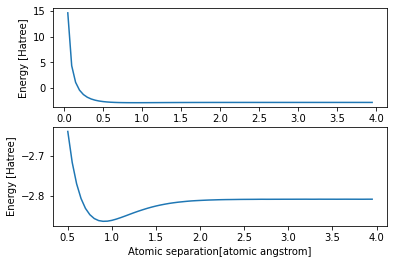

In [14]:
zoom_index = np.where(DM_groundEnergy_list < -2.6)
fig, (ax0, ax1) = plt.subplots(2, 1)
ax0.plot(DM_R_list, DM_groundEnergy_list)
ax0.set_xlabel("Atomic separation[atomic angstrom]")
ax0.set_ylabel("Energy [Hatree]")
ax1.plot(DM_R_list[zoom_index], DM_groundEnergy_list[zoom_index])
ax1.set_xlabel("Atomic separation[atomic angstrom]")
ax1.set_ylabel("Energy [Hatree]")
plt.show()  

## From circuit simulation based on Cirq

In [214]:
init_parameters = [np.pi*np.random.rand(), np.pi*np.random.rand(), np.pi*np.random.rand(), 2*np.pi*np.random.rand(), 2*np.pi*np.random.rand(), 2*np.pi*np.random.rand()]
operators = "XZ"
sub_Hamiltonian = {"11": 1.0}
a = get_expectation_from_operation(init_parameters, operators,  repetitions = 100)
bl = []
n = 50
for _ in range(n):
    b = measure_expectation_from_Cirq(init_parameters, operators,sub_Hamiltonian, repetitions = 100)
    bl.append(b)
a, np.array(bl).mean(), np.array(bl).std(), np.array(bl).std()/np.array(bl).mean()

(-0.13904429397580564,
 -0.14359999999999998,
 0.11032243652131692,
 -0.768262092766831)

In [272]:
get_expectation_from_Cirq(init_parameters,  H_df.iloc[32], repetitions = 10000)

-0.9235807699999999

In [279]:
R_list, groundState_list, groundEnergy_list, success_list = get_dissociation_curve(H_df, scale=None, maxiter = 1000, xatol= 1e-4, get_expectation_func = get_expectation_from_Cirq, repetitions=10000)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [2:22:33<00:00, 108.28s/it]

The minimum energy = -2.854087301, and its corresponding atomic separation = 0.9 Angstroms.


In [280]:
success_list

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

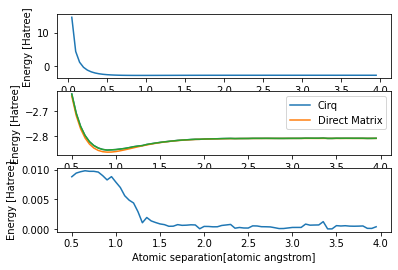

In [285]:
zoom_index = np.where(groundEnergy_list < -2.6)
fig, (ax0, ax1, ax2) = plt.subplots(3, 1)
ax0.plot(R_list, groundEnergy_list)
ax0.set_xlabel("Atomic separation[atomic angstrom]")
ax0.set_ylabel("Energy [Hatree]")

ax1.plot(R_list[zoom_index], groundEnergy_list[zoom_index])
zoom_index = np.where(DM_groundEnergy_list < -2.6)
ax1.plot(DM_R_list[zoom_index], DM_groundEnergy_list[zoom_index])
ax1.set_xlabel("Atomic separation[atomic angstrom]")
ax1.set_ylabel("Energy [Hatree]")
# ax1.legend()
ax1.legend(["Cirq", "Direct Matrix"])
ax1.plot(R_list[zoom_index], groundEnergy_list[zoom_index])

ax2.plot(DM_R_list[zoom_index], groundEnergy_list[zoom_index] - DM_groundEnergy_list[zoom_index])
ax2.set_xlabel("Atomic separation[atomic angstrom]")
ax2.set_ylabel("Energy [Hatree]")
plt.show()  